In [21]:
import os
import sys
print(os.environ.get("SPARK_HOME"))
print(os.environ.get("HADOOP_HOME"))
print(os.environ.get("JAVA_HOME"))
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

C:\Users\pedro\Spark\spark-3.5.0-bin-hadoop3
C:\Users\pedro\hadoop\bin
C:\Program Files\Java\jdk1.8.0_202


In [2]:
#from ReceitaCNPJApi import ReceitaCNPJApi
#from ReceitaLT import ReceitaLT
from pyspark.sql import SparkSession
import findspark
findspark.init()

In [3]:
spark = (SparkSession.builder
    .master("local[*]")  
    .config("spark.driver.cores", "3") 
    .config("spark.driver.memory", "15g") 
    .config("spark.default.parallelism", "50")
    .config("spark.sql.shuffle.partitions", "50") 
    .config("spark.executor.cores", "2")  
    .config("spark.executor.instances", "4") 
    .config("spark.executor.memory", "6g") 
    .config("spark.memory.fraction", "0.8") 
    .config("spark.memory.storageFraction", "0.5")
    .config("spark.memory.offHeap.enabled", "true") 
    .config("spark.memory.offHeap.size", "3g")  
    .config("spark.driver.maxResultSize", "10g")
    .config("spark.executor.memoryOverhead", "2g")  
    .config('spark.sql.repl.eagerEval.enabled', True)
    .config("spark.sql.repl.eagerEval.maxNumRows", 10)
    .appName('dataset_cnpj')
    .getOrCreate())

In [5]:
from functools import reduce
import os
import chardet
import logging
import glob
import secrets
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import regexp_replace, when,length,to_date,upper,lower,col,split,explode,coalesce,concat_ws,concat,lit,broadcast,regexp_extract,month,year,to_date
from pyspark.sql.functions import broadcast,expr,udf
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


In [189]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import lower, upper,row_number,isnan, when, count, col, coalesce, broadcast, regexp_replace, regexp_extract, lit
from pyspark.sql import functions as F, Window, Row
from pyspark.sql.functions import *
#from functools import reduce

#Pyspark
import py4j
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel

## Pacotes para configurar sessão no spark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
                            
## Pacote para localizar o path spark 
import findspark

# Pacote de geração de gráficos
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import missingno as msno #Pacote para ver dados missing
import plotly.express as px
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Tratamento Telefone

In [213]:
df = spark.read.parquet('C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS_CNPJ/df_final/')
dfv_cel = spark.read.option("header", "true").csv('C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS_CNPJ/DDD_OPERADORA_FAIXA_UF.csv')

In [244]:
dfv_cel.sample(0.20)

DDD,OPERADORA,faixa,UF,CIDADES_REGIOES_PRINCIPAIS
11,aeiou,97922,SP,Região Metropolit...
11,america_net,93500,SP,Região Metropolit...
11,claro,91312,SP,Região Metropolit...
11,claro,91317,SP,Região Metropolit...
11,claro,91323,SP,Região Metropolit...
11,claro,91346,SP,Região Metropolit...
11,claro,91355,SP,Região Metropolit...
11,claro,91357,SP,Região Metropolit...
11,claro,91363,SP,Região Metropolit...
11,claro,91365,SP,Região Metropolit...


In [214]:
df_tel = df.select('CPF_CRIPTOGRAFADO','NOME_EMPRESA','UF','DDD1','TEL1','DT_SIT_CADASTRAL','ano_sit_cadastral','ano_cadastro')
df_tel = df_tel.filter(col('TEL1').isNotNull())

In [215]:
df_tel = df_tel.withColumn("clean_tel1", regexp_replace("TEL1", "[^0-9]", ""))
df_tel = df_tel.withColumn("clean_ddd1", regexp_replace("DDD1", "[^0-9]", ""))
df_tel = df_tel.withColumn("len_tel1", length("clean_tel1"))
df_tel = df_tel.withColumn("len_ddd1", length("clean_ddd1"))
df_tel = df_tel.filter((col('len_ddd1') == 2) & (col('len_tel1') == 8))
df_tel = df_tel.withColumn("numero_1_tel1", substring(col("clean_tel1"), 1, 1))
df_tel = df_tel.withColumn("numero_4_tel1", substring(col("clean_tel1"), 1, 4))

In [216]:
# Criando a coluna TIPO_TELEFONE com regras condicionais
df_tel = df_tel.withColumn("TIPO_TELEFONE", 
    when((col("clean_ddd1") != "11") & (col("numero_1_tel1").isin(["2", "3", "4", "5"])), "TELEFONE FIXO")
    .when(col("numero_1_tel1").isin(["6", "7", "8", "9"]), "TELEFONE CELULAR")
    .when((col("clean_ddd1") == "11") & (col("numero_1_tel1").isin(["2", "3", "4"])), "TELEFONE FIXO")
    .otherwise("VALIDACAO_ESPECIAL"))

In [ ]:
# Pacotes básicos
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# Regex
import re

dfv = pd.DataFrame()
dfv = dfv.append(pd.DataFrame(data= {'ddd':11,'operadora':'oi','faixa': pd.Series(np.arange(5700,5768 )),'uf':'SP'}))
dfv = dfv.append(pd.DataFrame(data= {'ddd':11,'operadora':'tim','faixa': pd.Series(np.arange(5787,5799 )),'uf':'SP'}))
dfv = dfv.append(pd.DataFrame(data= {'ddd':11,'operadora':'tim','faixa': pd.Series(np.arange(5475,5499 )),'uf':'SP'}))
dfv = dfv.append(pd.DataFrame(data= {'ddd':11,'operadora':'vivo','faixa': pd.Series(np.arange(5472,5474 )),'uf':'SP'}))
dfv = dfv.append(pd.DataFrame(data= {'ddd':11,'operadora':'vivo','faixa': pd.Series(np.arange(5769,5786  )),'uf':'SP'}))
dfv_spark = spark.createDataFrame(dfv)

In [218]:
df_tel_alias = df_tel.alias("tel")
dfv_spark_alias = dfv_spark.alias("dfv")

df_tel_joined = df_tel_alias.join(dfv_spark_alias, 
                                  (col("tel.clean_ddd1") == col("dfv.ddd")) & 
                                  (col("tel.numero_4_tel1") == col("dfv.faixa")), 
                                  'left')

df_tel = df_tel_joined.withColumn("TIPO_TELEFONE_FINAL", 
                                         when((col("tel.TIPO_TELEFONE") == "VALIDACAO_ESPECIAL") & col("dfv.faixa").isNull(), "TELEFONE FIXO")
                                         .when((col("tel.TIPO_TELEFONE") == "VALIDACAO_ESPECIAL") & col("dfv.faixa").isNotNull(), "TELEFONE CELULAR")
                                         .otherwise(col("tel.TIPO_TELEFONE"))).drop("ddd","faixa","uf","operadora")

In [219]:
df_tel = df_tel.withColumn("cel_5_digitos", 
                           when(col("TIPO_TELEFONE_FINAL") == "TELEFONE CELULAR", 
                                concat(lit("9"), col("numero_4_tel1")))
                           .otherwise("TELEFONE FIXO"))

In [220]:
dfv_cel = dfv_cel.withColumn("faixa", regexp_replace("faixa", "\\.0$", ""))
df_tel = df_tel.join(dfv_cel, ((df_tel.cel_5_digitos == dfv_cel.faixa) & (df_tel.DDD1 == dfv_cel.DDD)) , 'left')

In [221]:
df_tel_hig = df_tel.select(col("CPF_CRIPTOGRAFADO"),
                           col("clean_tel1").alias("TEL1"),
                           col("clean_ddd1").alias("DDD1"),
                           col("TIPO_TELEFONE_FINAL").alias("TIPO_TELEFONE"),
                           col("OPERADORA"),
                           col("faixa").alias("FAIXA_CEL"),
                           col("UF"),
                           col("CIDADES_REGIOES_PRINCIPAIS"))

In [222]:
# Lista das colunas a serem selecionadas
colunas = [
    "CNPJ", "NOME_EMPRESA", "CAP_SOCIAL", "NM_PORTE", "NAT_JURICA", "ENTE_FEDERATIVO", 
    "NM_QUALIFICACAO", "CPF_CRIPTOGRAFADO", "CPF_LEN", "PROBABILIDADE_DE_SER_CPF", 
    "PRIMEIRO_NOME", "GRUPO_NOME", "PROBABILIDADE_CLASSIFICACAO", "CLASSIFICACAO", 
    "CNPJ_BASICO", "NM_MATRIZ_FILIAL", "NM_SIT_CADASTRAL", "DT_INICIO_ATIVIDADE", 
    "ENDERECO_COMPLETO", "TIPO_LOUGRADOURO", "CEP", "MUNICIPIO", 
    "DDD2", "TEL2", "valid_email", "PROVEDOR", "NM_MOTIVO", "CNAE", "NM_PAIS", 
    "ano_cadastro", "mes_cadastro", "DT_SIT_CADASTRAL", "ano_sit_cadastral", "mes_sit_cadastral"]

# Selecionando as colunas
df_filter = df.select(*colunas).dropDuplicates()

In [223]:
df_join = df_filter.join(df_tel_hig, df_filter.CPF_CRIPTOGRAFADO == df_tel_hig.CPF_CRIPTOGRAFADO, "left").drop(df_tel_hig.CPF_CRIPTOGRAFADO).cache()

In [247]:
df_join.write.mode("overwrite").parquet('C:/Users/pedro/Documents/Curso de pos graduação de EST/DADOS_CNPJ/df_telefone_tratado/')

In [246]:
df_join

CNPJ,NOME_EMPRESA,CAP_SOCIAL,NM_PORTE,NAT_JURICA,ENTE_FEDERATIVO,NM_QUALIFICACAO,CPF_LEN,PROBABILIDADE_DE_SER_CPF,PRIMEIRO_NOME,GRUPO_NOME,PROBABILIDADE_CLASSIFICACAO,CLASSIFICACAO,CNPJ_BASICO,NM_MATRIZ_FILIAL,NM_SIT_CADASTRAL,DT_INICIO_ATIVIDADE,ENDERECO_COMPLETO,TIPO_LOUGRADOURO,CEP,MUNICIPIO,DDD2,TEL2,valid_email,PROVEDOR,NM_MOTIVO,CNAE,NM_PAIS,ano_cadastro,mes_cadastro,DT_SIT_CADASTRAL,ano_sit_cadastral,mes_sit_cadastral,CPF_CRIPTOGRAFADO,TEL1,DDD1,TIPO_TELEFONE,OPERADORA,FAIXA_CEL,UF,CIDADES_REGIOES_PRINCIPAIS
25340623,GERALDO MIRANDA C...,"125000,00",MICRO EMPRESA,Empresa Individua...,NULL,Titular Pessoa Fí...,11,SIM,GERALDO,GERALDO,1.0,M,25340623,MATRIZ,BAIXADA,2016-08-02,RUA AMERICO TOTTI...,RUA,37131460,ALFENAS,NULL,NULL,maananias@uol.com.br,UOL,EXTINCAO POR ENCE...,Transporte rodovi...,NULL,2016,8,2021-04-22,2021,4,13UFXDVZ++GcMLM1Y...,99740745,35,TELEFONE CELULAR,vivo,99974,MG,Alfenas/Guaxupé/L...
45736621,SISTILIO RIBEIRO ...,"10000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,SISTILIO,NULL,NULL,NULL,45736621,MATRIZ,ATIVA,2022-03-22,10A AVENIDA OSTER...,10A AVENIDA,68380000,SAO FELIX DO XINGU,NULL,NULL,sistilioribeiroxi...,GMAIL,SEM MOTIVO,Serviços de malot...,NULL,2022,3,2022-03-22,2022,3,69vhDVxw0mUS4g2Vo...,99049089,94,TELEFONE CELULAR,tim,99904,PA,Marabá
46424494,GIRLLES AMORIM DA...,"60000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,GIRLLES,NULL,NULL,NULL,46424494,MATRIZ,ATIVA,2022-05-17,10A AVENIDA MUNIS...,10A AVENIDA,68488000,BREU BRANCO,NULL,NULL,girllesamorimdasi...,GMAIL,SEM MOTIVO,Comércio varejist...,NULL,2022,5,2022-05-17,2022,5,7iwaU0v0OQdJ3rZbe...,91699781,94,TELEFONE CELULAR,vivo,99169,PA,Marabá
40533060,WALERY LEITE ESTE...,"5000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,WALERY,NULL,NULL,NULL,40533060,MATRIZ,BAIXADA,2021-01-23,10A AVENIDA FRANC...,10A AVENIDA,65800000,BALSAS,NULL,NULL,waleryestevinho@g...,GMAIL,EXTINCAO POR ENCE...,Manutenção e repa...,NULL,2021,1,2021-07-26,2021,7,7vwxpcSP93ONA0Pju...,88856673,21,TELEFONE CELULAR,tim,98885,RJ,Rio de Janeiro e ...
48652567,KEDLANY FERREIRA ...,"10000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,KEDLANY,NULL,NULL,NULL,48652567,MATRIZ,ATIVA,2022-11-18,10A AVENIDA AV.DR...,10A AVENIDA,63380000,BARRO,NULL,NULL,dyegomuriel.engen...,GMAIL,SEM MOTIVO,"Lanchonetes, casa...",NULL,2022,11,2022-11-18,2022,11,9sH5RrHdX6ZmvRime...,99680482,88,TELEFONE CELULAR,tim,99968,CE,Juazeiro do Norte...
23752296,JOSE MARIA FERNAN...,"80000,00",MICRO EMPRESA,Empresa Individua...,NULL,Titular Pessoa Fí...,11,SIM,JOSE,JOSE,0.5957446808510638,M,23752296,MATRIZ,BAIXADA,2015-11-27,"RUA IVO AMARAL, 1...",RUA,38880000,TIROS,34,88090622,celsinha@uol.com.br,UOL,EXTINCAO POR ENCE...,Transporte rodovi...,NULL,2015,11,2020-03-03,2020,3,9vhnsvDLbP52XPNSv...,38531006,34,TELEFONE FIXO,NULL,NULL,NULL,NULL
40839077,EDIONY CARLOS DE ...,"5000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,EDIONY,NULL,NULL,NULL,40839077,MATRIZ,ATIVA,2021-02-12,10A AVENIDA ARAGU...,10A AVENIDA,76720000,ARAGUAPAZ,NULL,NULL,contabilidadearag...,HOTMAIL,SEM MOTIVO,"Lanchonetes, casa...",NULL,2021,2,2021-02-12,2021,2,KB3j9TQoLXh2jCBh1...,33801223,62,TELEFONE FIXO,NULL,NULL,NULL,NULL
28121617,ALEKCA CALAZANS N...,"5000,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,ALEKCA,NULL,NULL,NULL,28121617,MATRIZ,ATIVA,2017-07-06,10A AVENIDA AUGUS...,10A AVENIDA,45860000,CANAVIEIRAS,NULL,NULL,alekcacalazans@ho...,HOTMAIL,SEM MOTIVO,Comércio varejist...,NULL,2017,7,2017-07-06,2017,7,LpHJqpvjFJOokbKG8...,99484204,73,TELEFONE CELULAR,tim,99948,BA,Eunápolis/Ilhéus/...
34696412,ABIMAELY KEZIA MA...,"150,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,11,SIM,ABIMAELY,NULL,NULL,NULL,34696412,MATRIZ,BAIXADA,2019-08-29,1A RUA ELY ARAUJO...,1A RUA,59380000,CURRAIS NOVOS,NULL,NULL,paulovitor-25@liv...,LIVE,EXTINCAO POR ENCE...,Comércio varejist...,NULL,2019,8,2022-06-29,2022,6,M4x6mzG7gD1vcDMwK...,99902491,84,TELEFONE CELULAR,t

In [225]:
df_join.count()

21633869

In [226]:
df_join.dropDuplicates().count()

19941823

In [199]:
%%time
df = df_tel_hig.groupBy('TIPO_TELEFONE').count().orderBy(col('count').desc()).toPandas()
df

CPU times: total: 0 ns
Wall time: 2.72 s


,TIPO_TELEFONE,count
0,TELEFONE CELULAR,14568424
1,TELEFONE FIXO,6769716


In [245]:
df

CNPJ,NOME_EMPRESA,CAP_SOCIAL,NM_PORTE,NAT_JURICA,ENTE_FEDERATIVO,NM_QUALIFICACAO,CPF_CRIPTOGRAFADO,CPF_LEN,PROBABILIDADE_DE_SER_CPF,PRIMEIRO_NOME,GRUPO_NOME,PROBABILIDADE_CLASSIFICACAO,CLASSIFICACAO,CNPJ_BASICO,NM_MATRIZ_FILIAL,NM_SIT_CADASTRAL,DT_INICIO_ATIVIDADE,ENDERECO_COMPLETO,TIPO_LOUGRADOURO,CEP,UF,MUNICIPIO,DDD1,TEL1,DDD2,TEL2,valid_email,PROVEDOR,NM_MOTIVO,CNAE,NM_PAIS,ano_cadastro,mes_cadastro,DT_SIT_CADASTRAL,ano_sit_cadastral,mes_sit_cadastral
00152842,JOSE AGOSTINHO FU...,"500,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,FqZcgBeH9ms1IALMg...,11,SIM,JOSE,JOSE,0.5957446808510638,M,00152842,MATRIZ,BAIXADA,1994-07-28,"RUA PERIGUARI, 19...",RUA,3718050,SP,SAO PAULO,11,38814804,NULL,NULL,escritoriocontabi...,GMAIL,EXTINCAO POR ENCE...,Comércio varejist...,NULL,1994,7,2017-07-07,2017,7
00241892,FRANCISCO VALDEVI...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,t66maKwnTOk7rVkve...,11,SIM,FRANCISCO,FRANCISCO,1.0,M,00241892,MATRIZ,ATIVA,1994-10-13,RUA FLORENCIO TAB...,RUA,62665000,CE,SAO LUIS DO CURU,NULL,NULL,NULL,NULL,NULL,NULL,SEM MOTIVO,Comércio varejist...,NULL,1994,10,2005-11-03,2005,11
00284227,EDITE FARIAS LIMA...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,efpBefcl2huls+jyV...,11,SIM,EDITE,EDITE,1.0,F,00284227,MATRIZ,INAPTA,1994-11-08,RUA SANTOS DUMONT...,RUA,63750000,CE,TAMBORIL,NULL,NULL,NULL,NULL,NULL,NULL,OMISSAO DE DECLAR...,Comercio varejist...,NULL,1994,11,2021-02-24,2021,2
00332760,MARIA DE LOURDES ...,"0,00",DEMAIS,Empresário (Indiv...,NULL,Empresário,nOMKjVGEA5O2rYjsO...,11,SIM,MARIA,MARIA,1.0,F,00332760,MATRIZ,BAIXADA,1994-12-05,"RUA V, 16, JANUAR...",RUA,39480000,MG,JANUARIA,NULL,NULL,NULL,NULL,NULL,NULL,INAPTIDAO (LEI 11...,Comércio varejist...,NULL,1994,12,2008-12-31,2008,12
00340464,DILSON PEREIRA DE...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,ul/lo0HkGvH0ccAt4...,11,SIM,DILSON,DILSON,1.0,M,00340464,MATRIZ,ATIVA,1994-11-28,RUA VEREADOR JOAO...,RUA,38700248,MG,PATOS DE MINAS,NULL,NULL,NULL,NULL,NULL,NULL,SEM MOTIVO,Comércio varejist...,NULL,1994,11,2000-12-23,2000,12
00380927,MARIA PATEK GORDI...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,8b1GJ9Ow/fbhoSGGb...,11,SIM,MARIA,MARIA,1.0,F,00380927,MATRIZ,ATIVA,1995-01-09,RUA DR HEITOR S D...,RUA,84130000,PR,PALMEIRA,NULL,NULL,NULL,NULL,NULL,NULL,SEM MOTIVO,Comércio varejist...,NULL,1995,1,2005-09-03,2005,9
00400145,EDMILSON MARCARIN...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,i3PqnoPsZi+D2mWYM...,11,SIM,EDMILSON,EDMILSON,1.0,M,00400145,MATRIZ,ATIVA,1995-01-17,"C�RREGO PANORAMA,...",C�RREGO,35280000,MG,ITABIRINHA,33,32471135,NULL,NULL,arycontabilidade@...,RALNET,SEM MOTIVO,Torrefação e moag...,NULL,1995,1,2005-11-03,2005,11
00420958,PEDRO AGNALDO DE ...,"0,00",MICRO EMPRESA,Empresário (Indiv...,NULL,Empresário,u1BUedpVO+71f1hsE...,11,SIM,PEDRO,PEDRO,1.0,M,00420958,MATRIZ,ATIVA,1995-02-07,"SITIO DIOGO, CAPE...",SITIO,37993000,MG,CAPETINGA,35,35431218,NULL,NULL,NULL,NULL,SEM MOTIVO,Comércio atacadis...,NULL,1995,2,2005-11-03,2005,11
00460032,PAULO GALVAO DA S...,"0,00",DEMAIS,Empresário (Indiv...,NULL,Empresário,WUOXFPjjYu5zp/1pp...,11,SIM,PAULO,PAULO,0.9795640326975477,M,00460032,MATRIZ,BAIXADA,1995-03-03,RUA DR. JOSE BALB...,RUA,37975000,MG,ITAU DE MINAS,NULL,NULL,NULL,NULL,NULL,NULL,EXTINCAO POR ENCE...,Comércio varejist...,NULL,1995,3,2003-10-13,2003,10
00460032,PAULO GALVAO DA S...,"0,00",DEMAIS,Empresário (Indiv...,NULL,Empresário,WUOXFPjjYu5zp/1pp...,11,SIM,PAULO,PAULO,0.9795640326975477,M,00460032,MATRIZ,BAIXADA,1995-03-03,RUA DR. JOSE BALB...,RUA,37975000,MG,ITAU DE MINAS,NULL,NULL,NULL,NULL,NULL,NULL,EXTINCAO POR ENCE...,Comércio varejist...,NULL,1995,3,2003-10-13,2003,10


In [108]:
%%time
df = df_tel_joined.groupBy('TIPO_TELEFONE_FINAL').count().orderBy(col('count').desc()).toPandas()
df

CPU times: total: 31.2 ms
Wall time: 43.9 s


,TIPO_TELEFONE_FINAL,count
0,TELEFONE CELULAR,14566787
1,TELEFONE FIXO,6769716


In [107]:
%%time
df = df_tel.groupBy('TIPO_TELEFONE').count().orderBy(col('count').desc()).toPandas()
df

CPU times: total: 15.6 ms
Wall time: 9.44 s


,TIPO_TELEFONE,count
0,TELEFONE CELULAR,14543116
1,TELEFONE FIXO,6361698
2,VALIDACAO_ESPECIAL,431689


In [16]:
%%time
df = df_tel.groupBy('len_ddd1').count().orderBy(col('count').desc()).toPandas()
df

CPU times: total: 0 ns
Wall time: 4.07 s


,len_ddd1,count
0,2,21403598
1,1,47816
2,3,1120
3,4,82


In [15]:
%%time
df_uf = df_tel.groupBy('len_tel1').count().orderBy(col('count').desc()).toPandas()
df_uf

,len_tel1,count
0,8,21339488
1,1,110295
2,7,2522
3,6,149
4,4,64
5,5,50
6,2,35
7,3,13


CPU times: total: 656 ms
Wall time: 6.83 s


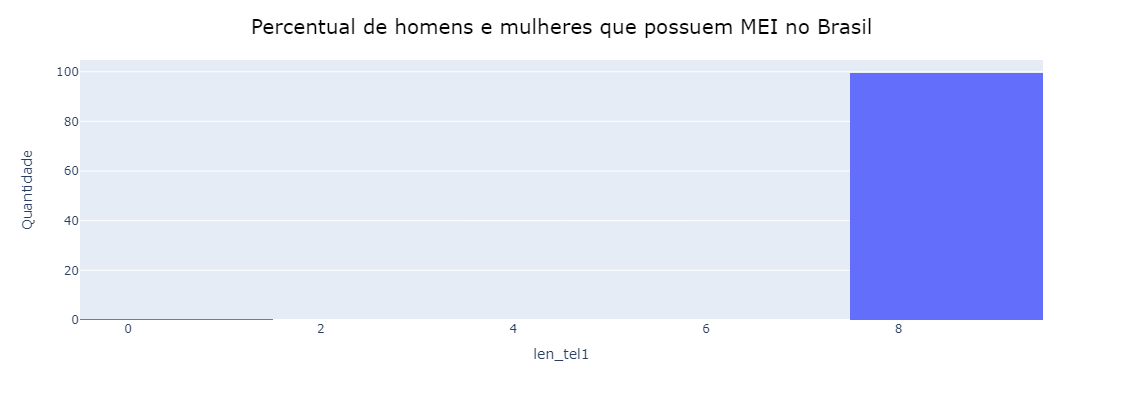

In [14]:
%%time
df_uf = df_tel.groupBy('len_tel1').count().orderBy(col('count').desc()).toPandas()

fig = px.histogram(df_uf,
             x = "len_tel1", 
             y='count',
             height = 400, width = 700,
             histnorm = 'percent')
fig.update_xaxes(title = "len_tel1")
fig.update_yaxes(title = "Quantidade")
#fig.show()
#py.plot(fig, filename = 'Count pnt', auto_open=True)
fig.update_layout(
    title={
        'text': "Percentual de homens e mulheres que possuem MEI no Brasil",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {
            'size': 20,
            'color': 'black'}})
